In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv()

try:
    conn = psycopg2.connect(
        dbname=os.getenv('dbname'),
        user=os.getenv('user'),
        password=os.getenv('password'),
        host=os.getenv('host'),
        port=os.getenv('port')
    )
    print("Connection to PostgreSQL successful\n")

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


query = "SELECT * FROM combined_indicators;"
df_all = pd.read_sql(query, conn)


df_all['ind_code'] = df_all['ind_code'].str.strip()


print("Available indicators:")
print(sorted(df_all['ind_code'].unique()))
print()


df = df_all.pivot_table(
    index='date_month',
    columns='ind_code',
    values='value'
).reset_index()

print(f"Data loaded: {df.shape}")
print(f"Columns: {sorted(df.columns.tolist())}\n")


df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month'])
df = df.asfreq('MS')

print("Data preparation completed\n")
df.info()

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df


Connection to PostgreSQL successful



/tmp/ipython-input-3252953170.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all = pd.read_sql(query, conn)


Available indicators:
['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']

Data loaded: (222, 11)
Columns: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP', 'date_month']

Data preparation completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2007-01-01 to 2025-06-01
Freq: MS
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EXR     222 non-null    float64
 1   OILP    222 non-null    float64
 2   PMI     222 non-null    float64
 3   TDC     222 non-null    float64
 4   TRI     222 non-null    float64
 5   TRP     222 non-null    float64
 6   TRPD    222 non-null    float64
 7   TRS     222 non-null    float64
 8   TRX     222 non-null    float64
 9   WRP     222 non-null    float64
dtypes: float64(10)
memory usage: 19.1 KB

Train data shape: (204, 10)
Test data shape: (18, 10)


/tmp/ipython-input-3252953170.py:43: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


ind_code,EXR,OILP,PMI,TDC,TRI,TRP,TRPD,TRS,TRX,WRP
date_month,,,,,,,,,,
2007-01-01,36.1800,2103.5052,54.8,30652000.0,55000.0,65.12,328940000.0,2.806710e+08,267567000.0,75.1683
2007-02-01,35.7500,2208.9925,55.1,26790000.0,44000.0,72.91,267868000.0,2.490050e+08,237979000.0,81.4653
2007-03-01,35.0600,2309.4022,53.1,31717000.0,119000.0,69.62,246813000.0,2.173390e+08,230410000.0,78.6261
2007-04-01,34.8700,2291.3077,56.1,27788000.0,184000.0,72.84,165458000.0,1.785750e+08,180185000.0,80.9071
2007-05-01,34.6200,2216.0262,58.6,32905000.0,91000.0,71.47,172153000.0,2.092150e+08,178103000.0,82.0040
...,...,...,...,...,...,...,...,...,...,...
2025-02-01,33.9385,2367.5498,50.2,109368000.0,63000.0,67.91,578922000.0,1.050152e+09,369222000.0,82.4825
2025-03-01,33.9768,2428.6617,50.5,95398000.0,111000.0,66.56,413728000.0,9.991970e+08,369396000.0,81.3680
2025-04-01,33.9148,1974.1805,49.0,69306000.0,73000.0,59.69,267722000.0,8.799700e+08,317716000.0,73.9204


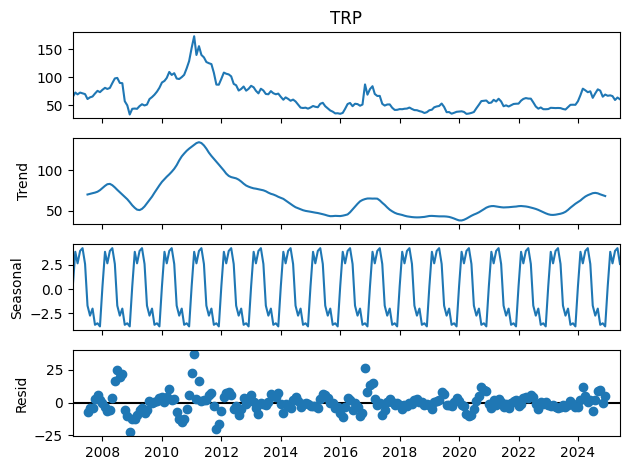

In [3]:
# Block 3 – Seasonal decomposition (เหมือนเดิม)

result = seasonal_decompose(df['TRP'], model='additive', period=12)
result.plot()
plt.show()


Available factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']
Selected factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

Train exogenous shape: (204, 9)
Test exogenous shape:  (18, 9)



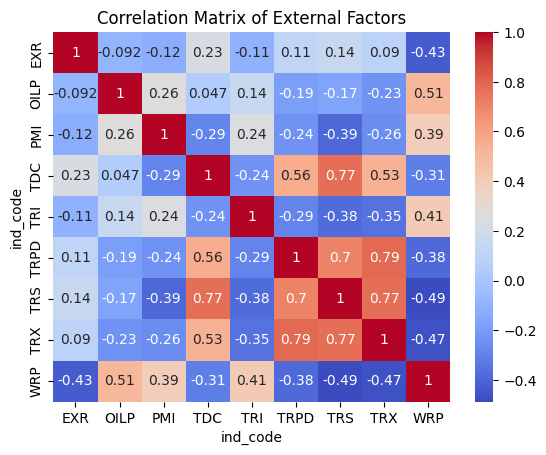


VIF of external factors:
  Feature         VIF
0     EXR  220.368075
1    OILP   18.588115
2     PMI  287.031566
3     TDC   17.668887
4     TRI    2.857776
5    TRPD   40.515663
6     TRS   24.810917
7     TRX   84.202948
8     WRP   18.112380

ADF Test for each external factor:
EXR: ADF Statistic = -2.7984, p-value = 0.0585
OILP: ADF Statistic = -2.9920, p-value = 0.0356
PMI: ADF Statistic = -6.2163, p-value = 0.0000
TDC: ADF Statistic = -0.2112, p-value = 0.9372
TRI: ADF Statistic = -2.2395, p-value = 0.1922
TRPD: ADF Statistic = -1.1591, p-value = 0.6909
TRS: ADF Statistic = -1.0853, p-value = 0.7209
TRX: ADF Statistic = -1.5220, p-value = 0.5226
WRP: ADF Statistic = -2.4895, p-value = 0.1180

Best Ridge alpha: 0.07847599703514611

Test RMSE: 2.3916
Test MAPE: 2.96%

External Factors Impact on Thai Rubber Price (Ridge coefficients):
  Factor  Coefficient
0    EXR     0.734049
1   OILP     0.258019
2    PMI     0.173513
3    TDC    -0.049001
4    TRI     0.237809
5   TRPD     0.449

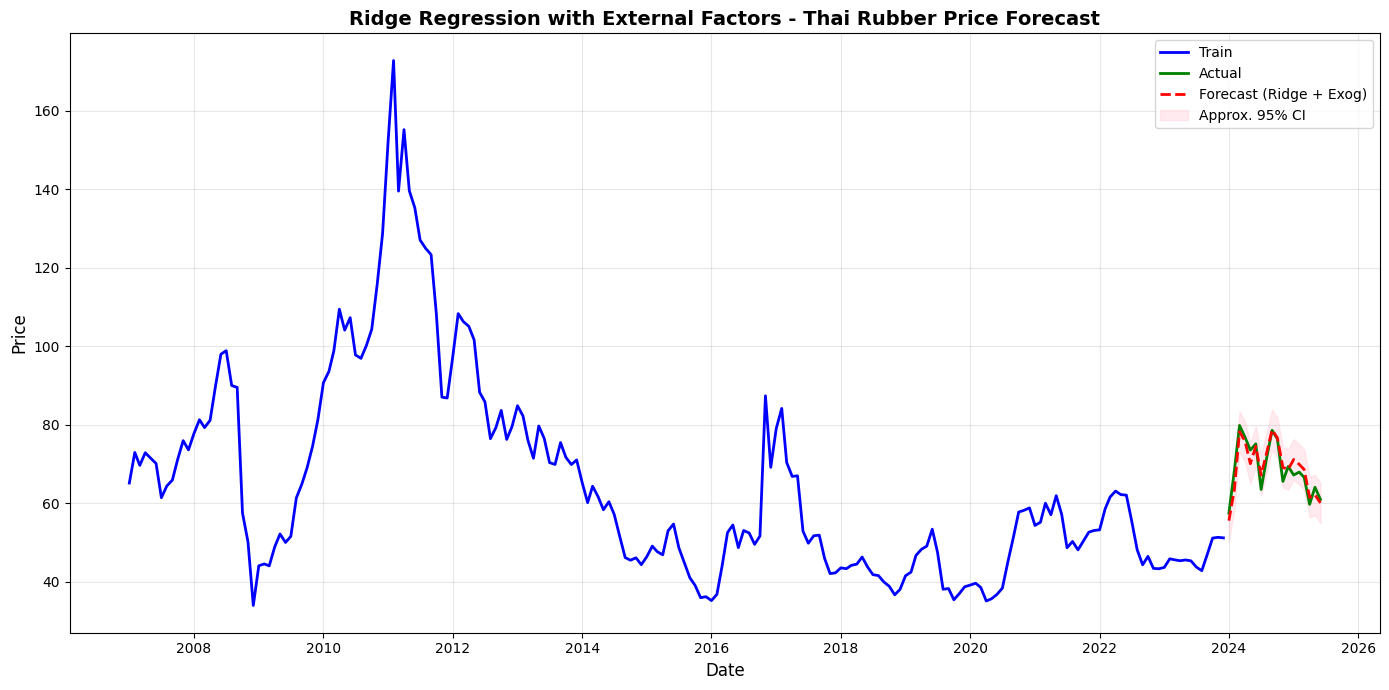

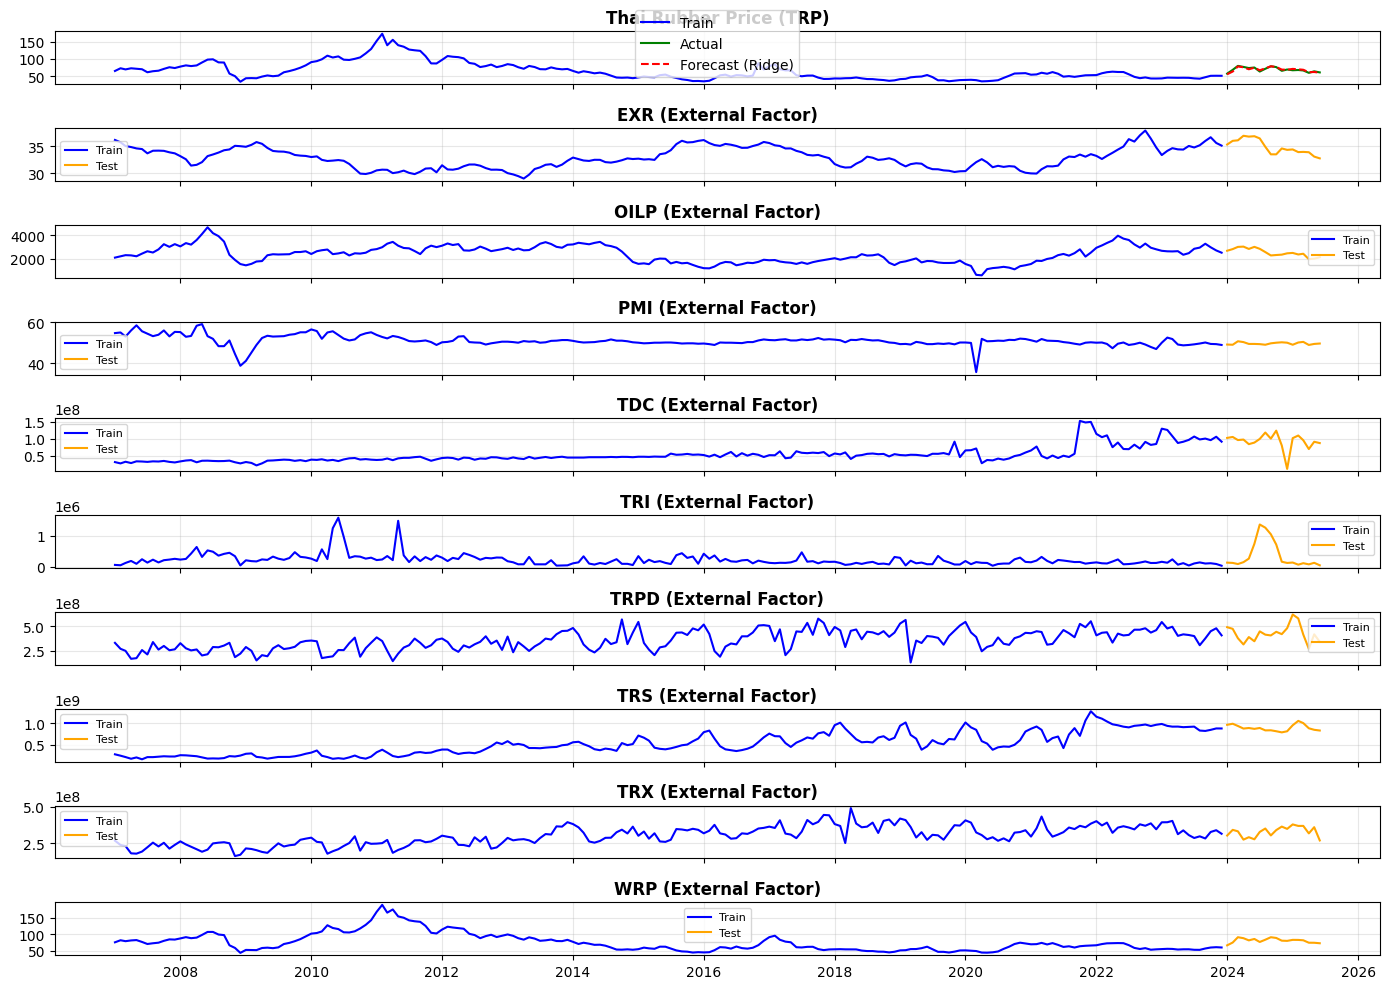

In [4]:
# Block 4 – Ridge Regression with external factors

external_factors = ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

print("Available factors:", df.columns.tolist())
print("Selected factors:", [f for f in external_factors if f in df.columns])
print()

# เตรียม exogenous variables
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

print(f"Train exogenous shape: {train_exog.shape}")
print(f"Test exogenous shape:  {test_exog.shape}\n")

# -----------------------------
# Heatmap ของ correlation matrix
# -----------------------------
correlation_matrix = train_exog.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of External Factors")
plt.show()

# -----------------------------
# คำนวณ VIF (Variance Inflation Factor)
# -----------------------------
vif_data = pd.DataFrame()
vif_data["Feature"] = external_factors
vif_data["VIF"] = [
    variance_inflation_factor(train_exog.values, i)
    for i in range(len(external_factors))
]
print("\nVIF of external factors:")
print(vif_data)

# -----------------------------
# ตรวจสอบ stationarity ของแต่ละตัวแปร (ADF)
# -----------------------------
print("\nADF Test for each external factor:")
for col in external_factors:
    result = adfuller(train_data[col].dropna())
    print(f"{col}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")

# =====================================================
#   สร้าง Ridge Regression + auto-parameter (alpha)
# =====================================================
X_train = train_exog
X_test  = test_exog
y_train = train_data['TRP']
y_test  = test_data['TRP']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ใช้ TimeSeriesSplit + GridSearchCV เลือก alpha ที่ดีที่สุด
alphas = np.logspace(-3, 3, 20)
tscv = TimeSeriesSplit(n_splits=5)

ridge_base = Ridge(random_state=42)
param_grid = {'alpha': alphas}

grid = GridSearchCV(
    ridge_base,
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

ridge_best = grid.best_estimator_
print("\nBest Ridge alpha:", grid.best_params_['alpha'])

# ทำนาย
train_pred = ridge_best.predict(X_train_scaled)
pred_mean  = ridge_best.predict(X_test_scaled)

# ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
mape = mean_absolute_percentage_error(y_test, pred_mean)

print(f"\nTest RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape*100:.2f}%\n")

# สร้าง approximate 95% CI จาก residual ของ train
residuals_train = y_train - train_pred
sigma = residuals_train.std(ddof=1)

pred_ci = pd.DataFrame({
    'lower': pred_mean - 1.96 * sigma,
    'upper': pred_mean + 1.96 * sigma
}, index=test_data.index)

# วิเคราะห์ coef ของ external factors
print("External Factors Impact on Thai Rubber Price (Ridge coefficients):")
coef_summary = pd.DataFrame({
    'Factor': external_factors,
    'Coefficient': ridge_best.coef_
})
print(coef_summary)
print()

# -----------------------------
# Plot: Train / Actual / Forecast + CI
# -----------------------------
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, y_train, label='Train', color='blue', linewidth=2)
plt.plot(test_data.index, y_test,  label='Actual', color='green', linewidth=2)
plt.plot(test_data.index, pred_mean, label='Forecast (Ridge + Exog)',
         color='red', linewidth=2, linestyle='--')

plt.fill_between(
    test_data.index,
    pred_ci['lower'],
    pred_ci['upper'],
    color='pink', alpha=0.3, label='Approx. 95% CI'
)

plt.title('Ridge Regression with External Factors - Thai Rubber Price Forecast',
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# Subplot แสดง TRP + external factors (เหมือนของเดิม)
# -----------------------------
fig, axes = plt.subplots(len(external_factors) + 1, 1, figsize=(14, 10), sharex=True)

# Main series
axes[0].plot(train_data.index, y_train, label='Train', color='blue')
axes[0].plot(test_data.index, y_test,  label='Actual', color='green')
axes[0].plot(test_data.index, pred_mean, label='Forecast (Ridge)', color='red', linestyle='--')
axes[0].set_title('Thai Rubber Price (TRP)', fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# External factors
for i, factor in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[factor], label='Train', color='blue')
    ax.plot(test_data.index, test_data[factor], label='Test', color='orange')
    ax.set_title(f'{factor} (External Factor)', fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
#PCA & Hybrid with Ridge Regression

external_factors = ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

print("Available factors:", df.columns.tolist())
print("Selected factors:", [f for f in external_factors if f in df.columns])
print()

train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

print(f"Train exogenous shape: {train_exog.shape}")
print(f"Test exogenous shape:  {test_exog.shape}\n")

#Standardize ก่อนทำ PCA

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_exog)
test_scaled  = scaler.transform(test_exog)


#Pure PCA + Ridge (auto alpha)
print("\nFinding Optimal PCA Components (Ridge + PCA)")
approach1_results = []

alphas = np.logspace(-3, 3, 15)
tscv = TimeSeriesSplit(n_splits=5)

for n_comp in range(2, 10):
    pca = PCA(n_components=n_comp)
    train_pca = pd.DataFrame(
        pca.fit_transform(train_scaled),
        index=train_data.index,
        columns=[f'PC{i+1}' for i in range(n_comp)]
    )
    test_pca = pd.DataFrame(
        pca.transform(test_scaled),
        index=test_data.index,
        columns=[f'PC{i+1}' for i in range(n_comp)]
    )

    explained_var = sum(pca.explained_variance_ratio_)

    print(f"\n{n_comp} Components: Explained Variance = {explained_var*100:.2f}%")

    try:
        ridge = Ridge()
        grid = GridSearchCV(
            ridge,
            {'alpha': alphas},
            cv=tscv,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        grid.fit(train_pca, train_data['TRP'])
        ridge_best = grid.best_estimator_

        pred_mean = ridge_best.predict(test_pca)

        rmse = np.sqrt(mean_squared_error(test_data['TRP'], pred_mean))
        mape = mean_absolute_percentage_error(test_data['TRP'], pred_mean) * 100

        approach1_results.append({
            'n_components': n_comp,
            'explained_var': explained_var,
            'RMSE': rmse,
            'MAPE': mape,
            'Best_alpha': grid.best_params_['alpha'],
            'model': ridge_best,
            'pred': pd.Series(pred_mean, index=test_data.index)
        })

        print(f"  Best alpha: {grid.best_params_['alpha']:.4f}")
        print(f"  RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

    except Exception as e:
        print(f"Error: {str(e)[:80]}")

print("\nSummary:")
results1_df = pd.DataFrame([
    {
        'Components': r['n_components'],
        'Explained Var': f"{r['explained_var']*100:.1f}%",
        'RMSE': r['RMSE'],
        'MAPE': f"{r['MAPE']:.2f}%",
        'Best_alpha': r['Best_alpha']
    }
    for r in approach1_results
])
print(results1_df.to_string(index=False))

best1 = min(approach1_results, key=lambda x: x['RMSE'])
print(f"\nBest PCA+Ridge: {best1['n_components']} components")
print(f"Explained Variance: {best1['explained_var']*100:.2f}%")
print(f"Best alpha: {best1['Best_alpha']:.4f}")
print(f"RMSE: {best1['RMSE']:.4f}")
print(f"MAPE: {best1['MAPE']:.2f}%")

# Approach 2: Hybrid (Key Factors + PCA) + Ridge
print("\n\nHybrid Approach (Key Factors + PCA) – Ridge")

key_factor_combinations = [
    (['WRP'], 'WRP only'),
    (['WRP', 'EXR'], 'WRP + EXR'),
    (['WRP', 'PMI'], 'WRP + PMI'),
    (['WRP', 'EXR', 'PMI'], 'WRP + EXR + PMI')
]

approach2_results = []

for key_factors, name in key_factor_combinations:
    print(f"\nTesting: {name}")
    print(f"Key factors: {key_factors}")

    other_factors = [f for f in external_factors if f not in key_factors]
    print(f"PCA factors: {other_factors}")

    if len(other_factors) == 0:
        print("No remaining factors for PCA, skip.")
        continue

    # scale remaining factors
    other_scaled = scaler.fit_transform(train_exog[other_factors])
    other_scaled_test = scaler.transform(test_exog[other_factors])

    for n_pca in [2, 3, 4]:
        if n_pca > len(other_factors):
            continue

        pca = PCA(n_components=n_pca)
        other_pca = pca.fit_transform(other_scaled)
        other_pca_test = pca.transform(other_scaled_test)

        # create hybrid dataset
        train_hybrid = pd.DataFrame(index=train_data.index)
        test_hybrid = pd.DataFrame(index=test_data.index)

        # key factors
        for kf in key_factors:
            train_hybrid[kf] = train_exog[kf].values
            test_hybrid[kf] = test_exog[kf].values

        # PCA components
        for i in range(n_pca):
            train_hybrid[f'PC{i+1}'] = other_pca[:, i]
            test_hybrid[f'PC{i+1}'] = other_pca_test[:, i]

        explained_var = sum(pca.explained_variance_ratio_)

        try:
            ridge = Ridge()
            grid = GridSearchCV(
                ridge,
                {'alpha': alphas},
                cv=tscv,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )

            grid.fit(train_hybrid, train_data['TRP'])
            ridge_best = grid.best_estimator_

            pred_mean = ridge_best.predict(test_hybrid)

            rmse = np.sqrt(mean_squared_error(test_data['TRP'], pred_mean))
            mape = mean_absolute_percentage_error(test_data['TRP'], pred_mean) * 100

            approach2_results.append({
                'name': name,
                'key_factors': key_factors,
                'n_pca': n_pca,
                'total_features': len(key_factors) + n_pca,
                'explained_var_pca': explained_var,
                'RMSE': rmse,
                'MAPE': mape,
                'Best_alpha': grid.best_params_['alpha'],
                'model': ridge_best,
                'pred': pd.Series(pred_mean, index=test_data.index)
            })

            print(f"{len(key_factors)} key + {n_pca} PCA = {len(key_factors)+n_pca} features")
            print(f"PCA explained: {explained_var*100:.1f}%")
            print(f"Best alpha: {grid.best_params_['alpha']:.4f}")
            print(f"RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

        except Exception as e:
            print(f"Error: {str(e)[:100]}")
            continue

print("\nSummary Hybrid:")
results2_df = pd.DataFrame([
    {
        'Strategy': r['name'],
        'Total Feat': r['total_features'],
        'RMSE': r['RMSE'],
        'MAPE': f"{r['MAPE']:.2f}%",
        'Best_alpha': r['Best_alpha']
    }
    for r in approach2_results
])
print(results2_df.to_string(index=False))

# Best hybrid model
best2 = min(approach2_results, key=lambda x: x['RMSE'])

print(f"\nBest Hybrid Ridge:")
print(f"Strategy: {best2['name']}")
print(f"Key Factors: {best2['key_factors']}")
print(f"PCA Components: {best2['n_pca']}")
print(f"Total Features: {best2['total_features']}")
print(f"Best alpha: {best2['Best_alpha']:.4f}")
print(f"RMSE: {best2['RMSE']:.4f}")
print(f"MAPE: {best2['MAPE']:.2f}%")


Available factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']
Selected factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

Train exogenous shape: (204, 9)
Test exogenous shape:  (18, 9)


Finding Optimal PCA Components (Ridge + PCA)

2 Components: Explained Variance = 59.21%
  Best alpha: 0.0010
  RMSE: 12.6919, MAPE: 16.91%

3 Components: Explained Variance = 70.45%
  Best alpha: 19.3070
  RMSE: 14.0135, MAPE: 18.42%

4 Components: Explained Variance = 79.49%
  Best alpha: 19.3070
  RMSE: 13.8165, MAPE: 18.08%

5 Components: Explained Variance = 88.21%
  Best alpha: 19.3070
  RMSE: 13.4570, MAPE: 17.76%

6 Components: Explained Variance = 92.79%
  Best alpha: 19.3070
  RMSE: 14.1526, MAPE: 18.85%

7 Components: Explained Variance = 96.21%
  Best alpha: 0.0193
  RMSE: 4.4929, MAPE: 5.44%

8 Components: Explained Variance = 98.55%
  Best alpha: 0.1389
  RMSE: 2.3813, MAPE: 2.93%

9 Components: Explained Variance = 100.00%
  Best alph


Final Model Comparison:
                 Method      RMSE      MAPE               Note
Original PCA (2-3 comp) 12.691851 16.909151       Baseline PCA
  Improved PCA (8 comp)  2.381277  2.926459    Explained 98.5%
     Hybrid (WRP + PMI)  2.460360  2.954834         5 features
  Domain (WRP+EXR_diff)  4.880000  6.480000 Reference baseline


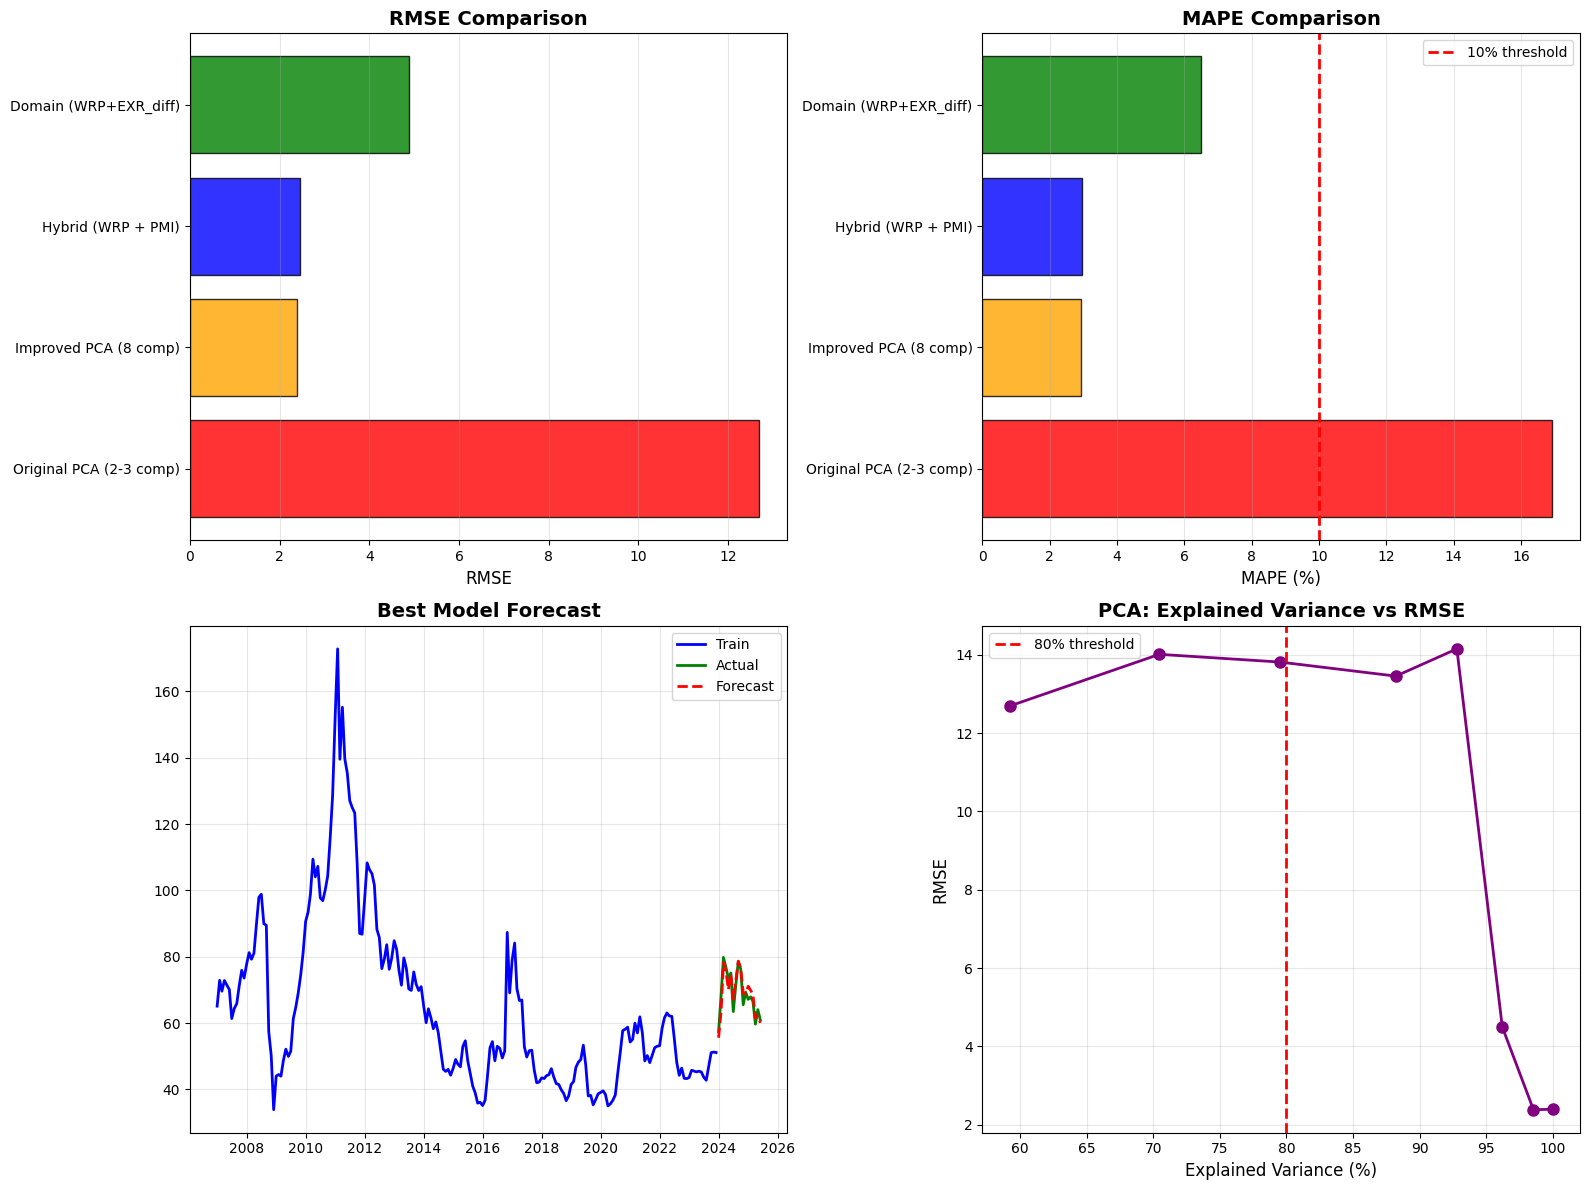

In [9]:
all_approaches = [
    {
        'Method': f'Original PCA (2-3 comp)',
        'RMSE': approach1_results[0]['RMSE'],
        'MAPE': approach1_results[0]['MAPE'],
        'Note': 'Baseline PCA'
    },
    {
        'Method': f'Improved PCA ({best1["n_components"]} comp)',
        'RMSE': best1['RMSE'],
        'MAPE': best1['MAPE'],
        'Note': f'Explained {best1["explained_var"]*100:.1f}%'
    },
    {
        'Method': f'Hybrid ({best2["name"]})',
        'RMSE': best2['RMSE'],
        'MAPE': best2['MAPE'],
        'Note': f'{best2["total_features"]} features'
    },
    {
        'Method': 'Domain (WRP+EXR_diff)',
        'RMSE': 4.88,
        'MAPE': 6.48,
        'Note': 'Reference baseline'
    }
]

comparison_df = pd.DataFrame(all_approaches)
print("\nFinal Model Comparison:")
print(comparison_df.to_string(index=False))


#พลอตกราฟ

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = [a['Method'] for a in all_approaches]
rmses = [a['RMSE'] for a in all_approaches]
mapes = [a['MAPE'] for a in all_approaches]

colors = ['red', 'orange', 'blue', 'green']

# RMSE Comparison
ax = axes[0, 0]
ax.barh(methods, rmses, color=colors, edgecolor='black', alpha=0.8)
ax.set_xlabel('RMSE', fontsize=12)
ax.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')


#MAPE Comparison

ax = axes[0, 1]
ax.barh(methods, mapes, color=colors, edgecolor='black', alpha=0.8)
ax.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10% threshold')
ax.set_xlabel('MAPE (%)', fontsize=12)
ax.set_title('MAPE Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')


#Best Ridge = RMSE ต่ำสุด
best_overall = best2 if best2['RMSE'] < best1['RMSE'] else best1

ax = axes[1, 0]
ax.plot(train_data.index, train_data['TRP'], label='Train', color='blue', linewidth=2)
ax.plot(test_data.index, test_data['TRP'], label='Actual', color='green', linewidth=2)
ax.plot(best_overall['pred'].index, best_overall['pred'],
        label='Forecast', color='red', linewidth=2, linestyle='--')

ax.set_title('Best Model Forecast', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)


#PCA Variance เทียบกับ RMSE
ax = axes[1, 1]
exp_vars = [r['explained_var'] * 100 for r in approach1_results]
rmse_list = [r['RMSE'] for r in approach1_results]

ax.plot(exp_vars, rmse_list, 'o-', linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Explained Variance (%)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('PCA: Explained Variance vs RMSE', fontsize=14, fontweight='bold')

ax.axvline(x=80, color='red', linestyle='--', linewidth=2, label='80% threshold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
